In [2]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [33]:
import math
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy,MeanAbsoluteError
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_probability as tfp

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

In [5]:
df_train.shape

(10407, 13)

In [6]:
df_test.shape

(6939, 12)

In [7]:
df_sub.shape

(6939, 2)

In [8]:
df_train = df_train.drop(['id'],axis=1)


In [9]:
df_test = df_test.drop(['id'],axis=1)

In [10]:
X = df_train.drop(['Hardness'],axis=1)
y = df_train.Hardness

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [28]:
# missing values
df_train.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [29]:
df_train.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


In [31]:
# allelectrons_Total
df_train['allelectrons_Total'].describe()

count    10407.000000
mean       128.053516
std        224.123776
min          0.000000
25%         68.000000
50%        100.000000
75%        131.000000
max      15300.000000
Name: allelectrons_Total, dtype: float64

In [14]:
from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error

lgb = LGBMRegressor()
lgb.fit(X, y)
y_pred = lgb.predict(X) 

In [15]:
def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

def metric_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q=0)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Dense

def build_model_using_sequential(input_shape):
    model = Sequential([
        BatchNormalization(epsilon=1e-5, input_shape=input_shape),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),        
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.013, beta_1=0.5),
                  loss=loss_fn,
                  metrics=metric_fn)
    
    return model

# Example of how to use the function with an input shape
input_shape = (len(X.columns), )
model = build_model_using_sequential(input_shape)

In [17]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min',
        patience=30, 
        restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    
]

In [18]:
history = model.fit(
    X_train.astype('float32'), 
    y_train.astype('float32'), 
    epochs=100, 
    batch_size=64,
    callbacks=callbacks_list,
    class_weight = lgb.class_weight,
    validation_split=0.1
)

Epoch 1/100
132/132 [==============================] - 3s 6ms/step - loss: 1.7991 - metric_fn: 8.4933 - val_loss: 1.6847 - val_metric_fn: 6.3280 - lr: 0.0130
Epoch 2/100
132/132 [==============================] - 0s 3ms/step - loss: 1.1217 - metric_fn: 6.7813 - val_loss: 0.9285 - val_metric_fn: 6.8403 - lr: 0.0130
Epoch 3/100
132/132 [==============================] - 0s 3ms/step - loss: 0.9768 - metric_fn: 5.5782 - val_loss: 0.8459 - val_metric_fn: 4.7868 - lr: 0.0130
Epoch 4/100
132/132 [==============================] - 0s 3ms/step - loss: 0.9385 - metric_fn: 4.7834 - val_loss: 0.8927 - val_metric_fn: 4.6525 - lr: 0.0130
Epoch 5/100
132/132 [==============================] - 0s 3ms/step - loss: 0.8479 - metric_fn: 4.5571 - val_loss: 0.8075 - val_metric_fn: 5.9072 - lr: 0.0130
Epoch 6/100
132/132 [==============================] - 0s 3ms/step - loss: 0.8517 - metric_fn: 4.7487 - val_loss: 1.1944 - val_metric_fn: 4.4334 - lr: 0.0130
Epoch 7/100
132/132 [==============================]

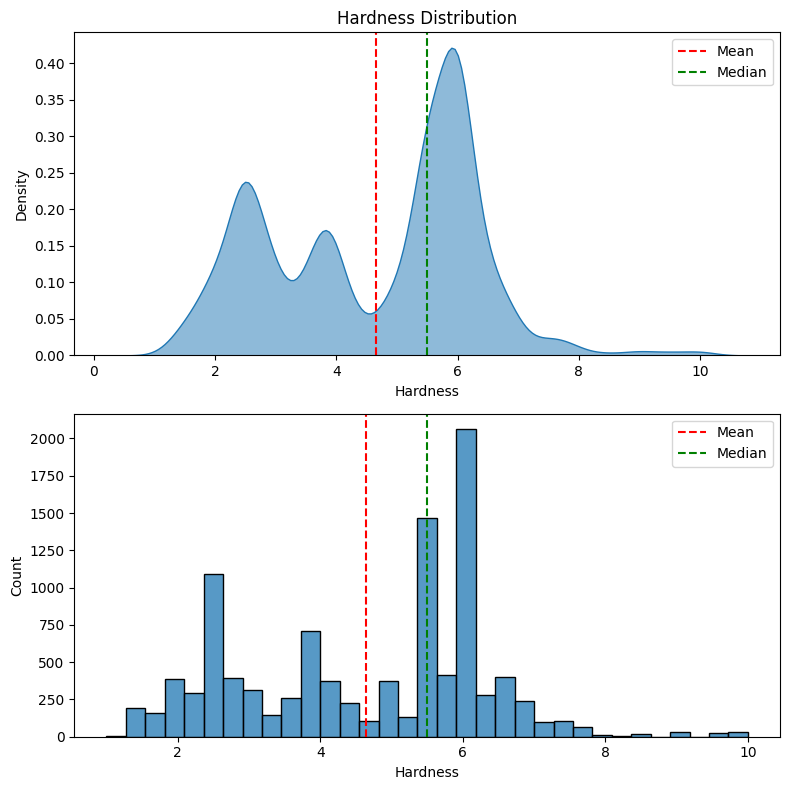

In [36]:
# Hardness distribution

# Create a subplot with two rows and one column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the distribution of Hardness using a density plot
sns.kdeplot(data=df_train['Hardness'], ax=ax1, fill=True, alpha=0.5)
ax1.axvline(x=df_train['Hardness'].mean(), color='red', linestyle='--', label='Mean')
ax1.axvline(x=df_train['Hardness'].median(), color='green', linestyle='--', label='Median')
ax1.legend()
ax1.set_xlabel('Hardness')
ax1.set_ylabel('Density')
ax1.set_title('Hardness Distribution')

# Plot the histogram of Hardness
sns.histplot(data=df_train['Hardness'], ax=ax2)
ax2.axvline(x=df_train['Hardness'].mean(), color='red', linestyle='--', label='Mean')
ax2.axvline(x=df_train['Hardness'].median(), color='green', linestyle='--', label='Median')
ax2.legend()
ax2.set_xlabel('Hardness')
ax2.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

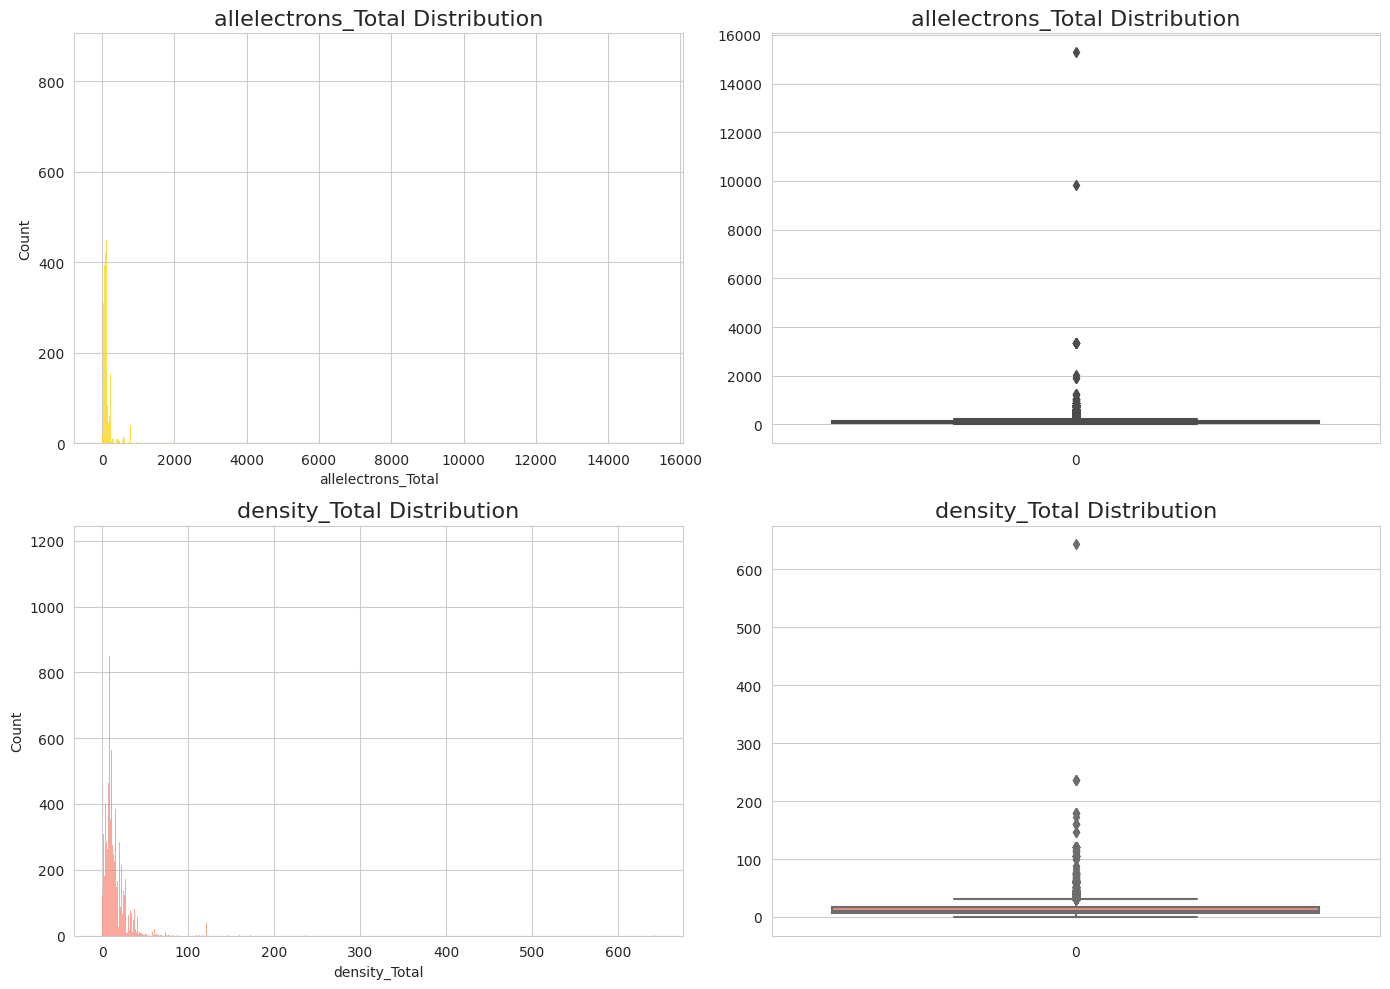

In [38]:
f1 = 'allelectrons_Total'
f2 = 'density_Total'

plt.figure(figsize=(14,10))
sns.set_style('whitegrid')
sns.set_palette('hsv')

plt.subplot(2,2,1)
ax = sns.histplot(df_train[f1])
ax.set_title(f'{f1} Distribution', fontdict={'fontsize':16})
plt.subplot(2,2,2)
ax = sns.boxplot(df_train[f1])
ax.set_title(f'{f1} Distribution', fontdict={'fontsize':16})

plt.subplot(2,2,3)
ax = sns.histplot(df_train[f2], color='salmon')
ax.set_title(f'{f2} Distribution', fontdict={'fontsize':16})
plt.subplot(2,2,4)
ax = sns.boxplot(df_train[f2], color='salmon')
ax.set_title(f'{f2} Distribution', fontdict={'fontsize':16})
plt.tight_layout()
plt.show()

<Axes: >

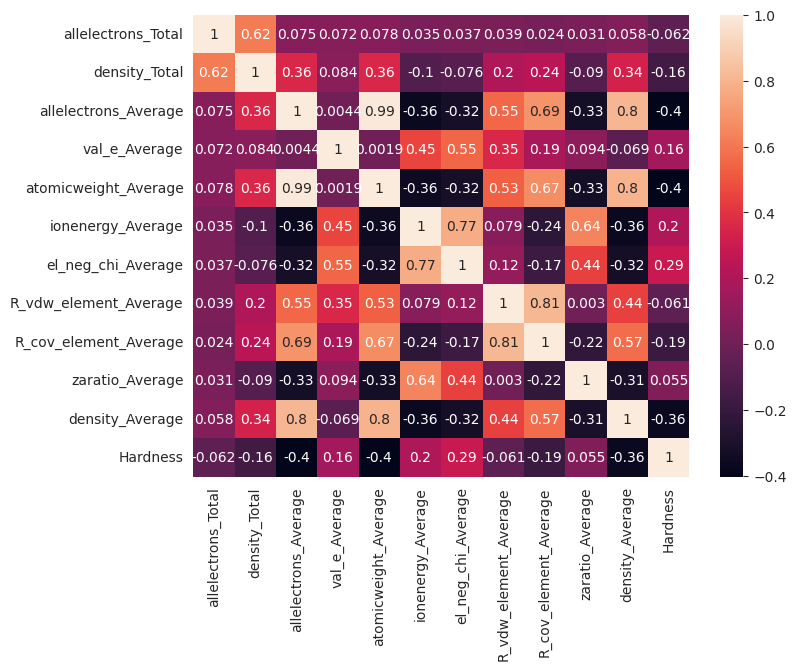

In [40]:
# heatmap of correlation between nummeric features
plt.figure(figsize=(8, 6))
sns.heatmap(df_train.corr(), annot=True)

<Axes: >

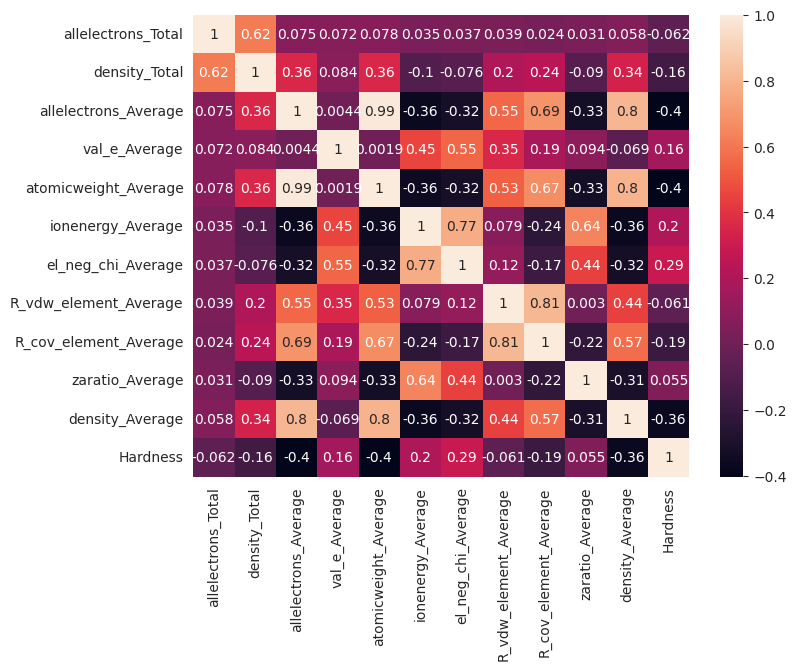

In [40]:
# heatmap of correlation between nummeric features
plt.figure(figsize=(8, 6))
sns.heatmap(df_train.corr(), annot=True)

In [19]:
# Make predictions using the trained model (y_pred will be a probability score)
y_pred = model.predict(df_test.astype('float32'))

217/217 [==============================] - 0s 1ms/step


In [20]:
y_pred

array([[2.4124274],
       [5.853479 ],
       [5.8305364],
       ...,
       [5.8492312],
       [5.2433853],
       [2.1216996]], dtype=float32)

In [21]:
df_sub['Hardness'] = y_pred

In [22]:
df_sub.to_csv('submission.csv',index=False)